In [1]:
!nvidia-smi

Thu Sep 21 05:44:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [52]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import numpy as np

In [3]:
# check if cuda is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
bs = 128
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 200276076.36it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 10917059.65it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21093330.60it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 24773119.33it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [5]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc11 = nn.Linear(10, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x, label_one_hot):
        h0 = F.relu(self.fc1(x))
        h1 = F.relu(self.fc11(label_one_hot))
        h2 = torch.add(h0, h1)
        h = F.relu(self.fc2(h2))
        return self.fc31(h), self.fc32(h) # mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        h = F.sigmoid(self.fc6(h))
        return h

    def forward(self, x, label_one_hot):
        mu, log_var = self.encoder(x.view(-1, 784), label_one_hot)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [6]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc11): Linear(in_features=10, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [7]:
vae.fc11.weight.dtype

torch.float32

In [8]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [9]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.float().cuda()
        label_one_hot = F.one_hot(label, 10).float().cuda()
        optimizer.zero_grad()

        recon_batch, mu, log_var = vae(data, label_one_hot)
        loss = loss_function(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [10]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, label in test_loader:
            data = data.float().cuda()
            label_one_hot = F.one_hot(label, 10).float().cuda()
            recon, mu, log_var = vae(data, label_one_hot)

            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [11]:
for epoch in range(1, 51):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 543.324707
Train Epoch: 1 [12800/60000 (21%)]	Loss: 188.906189
Train Epoch: 1 [25600/60000 (43%)]	Loss: 180.887146
Train Epoch: 1 [38400/60000 (64%)]	Loss: 171.969940
Train Epoch: 1 [51200/60000 (85%)]	Loss: 164.918045
====> Epoch: 1 Average loss: 183.5529
====> Test set loss: 163.1689
Train Epoch: 2 [0/60000 (0%)]	Loss: 160.769928
Train Epoch: 2 [12800/60000 (21%)]	Loss: 158.300064
Train Epoch: 2 [25600/60000 (43%)]	Loss: 157.243530
Train Epoch: 2 [38400/60000 (64%)]	Loss: 160.333710
Train Epoch: 2 [51200/60000 (85%)]	Loss: 159.082977
====> Epoch: 2 Average loss: 158.8240
====> Test set loss: 154.7376
Train Epoch: 3 [0/60000 (0%)]	Loss: 158.909943
Train Epoch: 3 [12800/60000 (21%)]	Loss: 153.666382
Train Epoch: 3 [25600/60000 (43%)]	Loss: 152.410522
Train Epoch: 3 [38400/60000 (64%)]	Loss: 151.342300
Train Epoch: 3 [51200/60000 (85%)]	Loss: 155.492401
====> Epoch: 3 Average loss: 152.8809
====> Test set loss: 151.6379
Train Epoch: 4 [0/60000 (0%)]	L

In [12]:
!mkdir './samples'

In [13]:
with torch.no_grad():
    z = torch.randn(64, 2).cuda()
    sample = vae.decoder(z).cuda()

    save_image(sample.view(64, 1, 28, 28), './samples/sample_' + '.png')

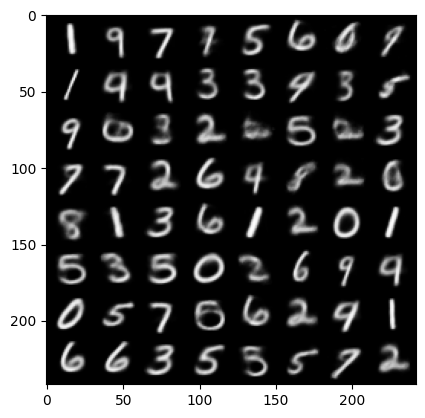

In [14]:
img = plt.imread('/content/samples/sample_.png')
plt.imshow(img)

In [103]:
def validate():
    vae.eval()
    with torch.no_grad():
        i = 0
        for data, label in val_loader:
            i += 1
            if i > 0:
                break

        print(f' Correct   label : {label.tolist()}')
        number_to_image(label.tolist(), '/content/samples/correct_label.png')
        data = data.float().cuda()
        label_one_hot_val = F.one_hot(label, 10).float().cuda()
        recon_val, mu_val, log_var_val = vae(data, label_one_hot_val)
        save_image(data, './samples/data_32' + '.png')
        save_image(recon_val.view(32, 1, 28, 28), './samples/sample_32_correct' + '.png')

        for lab in label:
            if lab == 9:
                lab -= 9
            else:
                lab += 1

        print(f' Modified  label : {label.tolist()}')
        number_to_image(label.tolist(), '/content/samples/modified_label.png')
        label_one_hot_val_wrong = F.one_hot(label, 10).float().cuda()
        recon_val_wrong, mu_val, log_var_val = vae(data, label_one_hot_val_wrong)
        save_image(recon_val_wrong.view(32, 1, 28, 28), './samples/sample_32_wrong' + '.png')

        input_arr   = np.asarray(Image.open('/content/samples/data_32.png'))
        correct_arr = np.asarray(Image.open('/content/samples/sample_32_correct.png'))
        wrong_arr   = np.asarray(Image.open('/content/samples/sample_32_wrong.png'))
        corr_label_arr = np.asarray(Image.open('/content/samples/correct_label.png'))
        mod_label_arr = np.asarray(Image.open('/content/samples/modified_label.png'))
        np_arr = np.stack((input_arr, correct_arr, wrong_arr, corr_label_arr, corr_label_arr, mod_label_arr))
        title_list = ['Original Input', 'Pred with correct labels', 'Pred with modified labels', \
                      'Original Label', 'Original Labels for Pred', 'Modified labels for Pred']

        plt.figure(figsize=(12, 12))
        for i in range(6):
            plt.subplot(2, 3, i + 1)
            plt.imshow(np_arr[i])
            plt.title(title_list[i])
            plt.axis('off')
        plt.show()

 Correct   label : [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1]
 Modified  label : [8, 3, 2, 1, 5, 2, 5, 0, 6, 0, 1, 7, 0, 1, 2, 6, 0, 8, 4, 5, 0, 7, 7, 6, 5, 1, 8, 5, 1, 2, 4, 2]


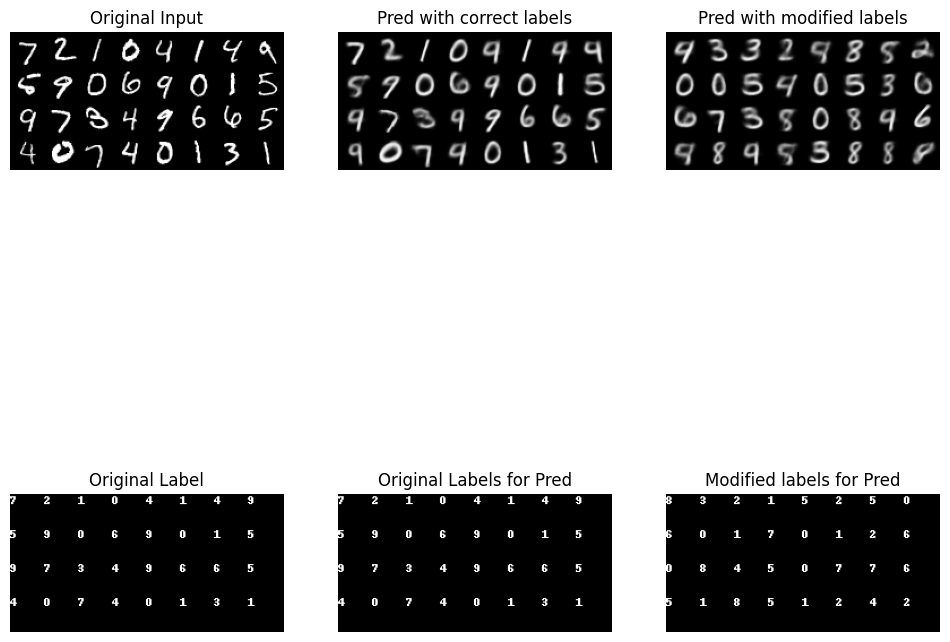

In [102]:
validate()

In [104]:
def number_to_image(num_list, image_save_name):
      # Determine the grid size (e.g., 4x8)
      num_rows = 4
      num_cols = 8
      image_width = 242  # Adjust as needed
      image_height = 122  # Adjust as needed

      # Create a blank image with a white background
      image = Image.new('RGB', (image_width, image_height), color='black')
      draw = ImageDraw.Draw(image)

      # Define the size of each cell in the grid
      cell_width = image_width // num_cols
      cell_height = image_height // num_rows

      # Loop through the numbers and draw them in a grid
      for i, number in enumerate(num_list):
          row = i // num_cols
          col = i % num_cols
          x = col * cell_width
          y = row * cell_height
          text = str(number)
          draw.text((x, y), text, fill='white')

      # Save the image as a PNG file
      image.save(image_save_name)